In [106]:
from phmd import datasets
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
TS = 32
EPOCHS = 100

datasets.Dataset.search(task='rul')


def window_split(X, unit_id, signal_cols, target_col, subsignal_length=1000, signal_max_length=20000):
    units_array = X[unit_id].values
    signal_array = X[signal_cols].values
    targets = X[target_col].values
    N = signal_max_length // subsignal_length

    num_units = X[unit_id].drop_duplicates().shape[0]
    unique_units = X[unit_id].drop_duplicates().values
    X = np.zeros((N * num_units, subsignal_length, len(signal_cols)))
    Y = np.zeros((N * num_units,))
    NN = 0
    for i, unit in enumerate(unique_units):
        mask = np.all(units_array == unit, axis=1)
        signal = signal_array[mask]
        sml = (signal.shape[0] // subsignal_length) * subsignal_length
        n = min(sml // subsignal_length, N)
        sml = subsignal_length * n
        signal = signal[-sml:]
        signal = signal.reshape((n, subsignal_length, len(signal_cols)))
        signal_target = targets[-sml:]
        signal_target = signal_target.reshape((n, subsignal_length))
        X[NN:NN + n] = signal
        Y[NN:NN + n] = signal_target[:, -1]
        NN += n

    X = X[:NN]

    return X, Y


def create_conv_1d_network(input_shape):

    input = tf.keras.layers.Input(input_shape)

    x = input

    for i in range(4):
        x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling1D(2)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='relu')(x)

    return tf.keras.models.Model(inputs=input, outputs=x)


def train(train_data, epochs, es=True, validation_data=None):
    X_train, Y_train = train_data
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)] if es else []
    valid_train = False
    while not valid_train:
        model = create_conv_1d_network(X_train.shape[1:])
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['mae'], loss='mse')
        
        results = model.fit(X_train, Y_train,
                           epochs=3,
                           batch_size=128,
                           verbose=1,
                           validation_data=validation_data,
                           callbacks=callbacks)

        #print(results.history['loss'], np.std(results.history['loss']) > 1e-3)
        valid_train = np.std(results.history['loss']) > 1e-3
        
    results = model.fit(X_train, Y_train,
                   epochs=epochs,
                   batch_size=128,
                   verbose=1,
                   validation_data=validation_data,
                   callbacks=callbacks)
    return results, model

name        domain                 nature       application     task [target var]                                                 data nature    features                                                                     publisher
----------  ---------------------  -----------  --------------  ----------------------------------------------------------------  -------------  ---------------------------------------------------------------------------  ---------------------------------------------------------------------
ARAMIS20    Simulation             time-series  Unknown         Prognosis [rul]                                                   time-series    Unkown                                                                       Aramis
CALCE_CS2   Electrical component   time-series  Battery         Prognosis [rul]                                                   time-series    impedance,energy,capacity,current,voltage,resistance                         Center of Advanced Life C

In [114]:
DATASETS = ['PHME20', 'ARAMIS20', 'CALCE_CS2']

#predictions = {}
for dataset in DATASETS:
    ds = datasets.Dataset(dataset)
    
    task = ds['rul']
    task.folds = 3
    task.normalize_output = True
    task.preprocess = MinMaxScaler()
    
    TS = min(1024, ds['rul'].meta['min_ts_len'] // 20)
    ea_epochs = []
    
    unit_id = ds['rul'].meta['identifier']
    EPOCHS = 100
    for i in range(task.folds):
        data = task[i]
        
        X_train, X_val, X_test = data['train'],  data['val'],  data['test']
        
        signal_sizes = [X_train.groupby(unit_id).size().min(),
                        X_val.groupby(unit_id).size().min(),
                        X_test.groupby(unit_id).size().min()]
        
        signal_max_length = min(np.min(signal_sizes), 20000000)
        
        X_train, Y_train = window_split(X_train, unit_id, ds['rul'].meta['features'], 'rul', TS, signal_max_length)
        X_val, Y_val = window_split(X_val, unit_id, ds['rul'].meta['features'], 'rul', TS, signal_max_length)

        results, model = train((X_train, Y_train), EPOCHS, es=True, validation_data=(X_val, Y_val))

        ea_epochs.append(len(results.history['loss']))
    
    # Train final model with all training data
    train_data = np.concatenate((X_train, X_val)), np.concatenate((Y_train, Y_val))
    results, model = train(train_data, int(np.mean(ea_epochs)), es=False, validation_data=None)

    
    
    # Predict on one unit of the test set
    unit = np.unique(X_test[ds['rul'].meta['identifier']].values)[0]
    unit_mask = np.all(X_test[ds['rul'].meta['identifier']] == unit, axis=1)
    aux = X_test[unit_mask]
    X_aux, Y_aux = window_split(aux, unit_id, ds['rul'].meta['features'], 'rul', TS, signal_max_length)
    Y_pred = model.predict(X_aux)

    X_test, Y_test = window_split(X_test, unit_id, ds['rul'].meta['features'], 'rul', TS, signal_max_length)
    results = model.evaluate(X_test, Y_test)

    predictions[dataset] = [Y_aux, Y_pred, results]

Dataset PHME20 already downloaded and extracted
Remember to cite the original publisher dataset:
	@InProceedings{PHME20-GTU,
	    author = {Kürşat İnce and Engin Sirkeci and Yakup Genç},
	    title = {Remaining Useful Life Prediction for Experimental Filtration System: A Data Challenge},
	    booktitle = {Proceedings of the European Conference of the PHM Society 2020},
	    month = July,
	    year = 2020,
	    publisher = {PHM Society},
	    editor = {Anibal Bregon & Kamal Medjaher},
	    note = {Available at https://phmpapers.org/index.php/phme/article/view/1317}
	}
You can download the dataset manually from:  https://github.com/zakkum42/phme20-public

** If you find this tool useful, please cite our SoftwareX paper.



Reading : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 118.76it/s]
INFO:root:Read in 0.2824876308441162 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi),Particle Size (micron),Solid Ratio(%),rul,unit
INFO:root:Train shape: (37460, 7)
INFO:root:Val shape: (16534, 7)
INFO:root:Test shape: (21800, 7)
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/3
3/3 [==============================] - 1s 181ms/step - loss: 0.3000 - mae: 0.4677 - val_loss: 0.2172 - val_mae: 0.3967
Epoch 2/3
3/3 [==============================] - 0s 73ms/step - loss: 0.2920 - mae: 0.4599 - val_loss: 0.2092 - val_mae: 0.3874
Epoch 3/3
3/3 [==============================] - 0s 66ms/step - loss: 0.2828 - mae: 0.4506 - val_loss: 0.1981 - val_mae: 0.3742
Epoch 1/100
3/3 [==============================] - 0s 74ms/step - loss: 0.2697 - mae: 0.4374 - val_loss: 0.1828 - val_mae: 0.3565
Epoch 2/100
3/3 [==============================] - 0s 67ms/step - loss: 0.2514 - mae: 0.4186 - val_loss: 0.1623 - val_mae: 0.3322
Epoch 3/100
3/3 [==============================] - 0s 61ms/step - loss: 0.2270 - mae: 0.3947 - val_loss: 0.1354 - val_mae: 0.3007
Epoch 4/100
3/3 [==============================] - 0s 68ms/step - loss: 0.1947 - mae: 0.3611 - val_loss: 0.1024 - val_mae: 0.2619
Epoch 5/100
3/3 [==============================] - 0s 69ms/step - loss: 0.1551 - mae: 0.3223 - 

Reading : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 156.60it/s]
INFO:root:Read in 0.22214770317077637 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi),Particle Size (micron),Solid Ratio(%),rul,unit
INFO:root:Train shape: (34744, 7)
INFO:root:Val shape: (19250, 7)
INFO:root:Test shape: (21800, 7)
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/3
3/3 [==============================] - 1s 133ms/step - loss: 0.2219 - mae: 0.4018 - val_loss: 0.2905 - val_mae: 0.4584
Epoch 2/3
3/3 [==============================] - 0s 59ms/step - loss: 0.2127 - mae: 0.3914 - val_loss: 0.2779 - val_mae: 0.4456
Epoch 3/3
3/3 [==============================] - 0s 72ms/step - loss: 0.2011 - mae: 0.3776 - val_loss: 0.2611 - val_mae: 0.4280
Epoch 1/100
3/3 [==============================] - 0s 69ms/step - loss: 0.1848 - mae: 0.3589 - val_loss: 0.2378 - val_mae: 0.4050
Epoch 2/100
3/3 [==============================] - 0s 63ms/step - loss: 0.1635 - mae: 0.3339 - val_loss: 0.2066 - val_mae: 0.3739
Epoch 3/100
3/3 [==============================] - 0s 81ms/step - loss: 0.1353 - mae: 0.3007 - val_loss: 0.1676 - val_mae: 0.3350
Epoch 4/100
3/3 [==============================] - 0s 71ms/step - loss: 0.1038 - mae: 0.2637 - val_loss: 0.1248 - val_mae: 0.2922
Epoch 5/100
3/3 [==============================] - 0s 67ms/step - loss: 0.0713 - mae: 0.2243 - 

Reading : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 156.88it/s]
INFO:root:Read in 0.22379398345947266 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi),Particle Size (micron),Solid Ratio(%),rul,unit
INFO:root:Train shape: (35784, 7)
INFO:root:Val shape: (18210, 7)
INFO:root:Test shape: (21800, 7)
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/3
3/3 [==============================] - 1s 128ms/step - loss: 0.2222 - mae: 0.4021 - val_loss: 0.2447 - val_mae: 0.4211
Epoch 2/3
3/3 [==============================] - 0s 58ms/step - loss: 0.2159 - mae: 0.3950 - val_loss: 0.2370 - val_mae: 0.4127
Epoch 3/3
3/3 [==============================] - 0s 56ms/step - loss: 0.2077 - mae: 0.3856 - val_loss: 0.2266 - val_mae: 0.4010
Epoch 1/100
3/3 [==============================] - 0s 77ms/step - loss: 0.1966 - mae: 0.3721 - val_loss: 0.2125 - val_mae: 0.3855
Epoch 2/100
3/3 [==============================] - 0s 62ms/step - loss: 0.1817 - mae: 0.3548 - val_loss: 0.1934 - val_mae: 0.3646
Epoch 3/100
3/3 [==============================] - 0s 68ms/step - loss: 0.1612 - mae: 0.3310 - val_loss: 0.1681 - val_mae: 0.3374
Epoch 4/100
3/3 [==============================] - 0s 57ms/step - loss: 0.1348 - mae: 0.3000 - val_loss: 0.1365 - val_mae: 0.3033
Epoch 5/100
3/3 [==============================] - 0s 57ms/step - loss: 0.1039 - mae: 0.2648 - 

Reading : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.37s/it]
INFO:root:Read in 4.535414218902588 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,component,unit,rul
INFO:root:Train shape: (187830, 13)
INFO:root:Val shape: (101832, 13)
INFO:root:Test shape: (119535, 13)
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/3
30/30 [==============================] - 2s 41ms/step - loss: 0.1226 - mae: 0.2814 - val_loss: 0.0525 - val_mae: 0.1985
Epoch 2/3
30/30 [==============================] - 1s 35ms/step - loss: 0.0405 - mae: 0.1700 - val_loss: 0.0241 - val_mae: 0.1263
Epoch 3/3
30/30 [==============================] - 1s 35ms/step - loss: 0.0192 - mae: 0.1124 - val_loss: 0.0162 - val_mae: 0.1041
Epoch 1/100
30/30 [==============================] - 1s 37ms/step - loss: 0.0125 - mae: 0.0881 - val_loss: 0.0126 - val_mae: 0.0878
Epoch 2/100
30/30 [==============================] - 1s 35ms/step - loss: 0.0075 - mae: 0.0626 - val_loss: 0.0095 - val_mae: 0.0668
Epoch 3/100
30/30 [==============================] - 1s 35ms/step - loss: 0.0056 - mae: 0.0495 - val_loss: 0.0090 - val_mae: 0.0635
Epoch 4/100
30/30 [==============================] - 1s 36ms/step - loss: 0.0046 - mae: 0.0427 - val_loss: 0.0089 - val_mae: 0.0620
Epoch 5/100
30/30 [==============================] - 1s 40ms/step - loss: 0.0044 -

Reading : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.06s/it]
INFO:root:Read in 5.231661319732666 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,component,unit,rul
INFO:root:Train shape: (186749, 13)
INFO:root:Val shape: (102913, 13)
INFO:root:Test shape: (119535, 13)
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/3
30/30 [==============================] - 2s 40ms/step - loss: 0.1177 - mae: 0.2763 - val_loss: 0.0580 - val_mae: 0.2084
Epoch 2/3
30/30 [==============================] - 1s 35ms/step - loss: 0.0455 - mae: 0.1812 - val_loss: 0.0317 - val_mae: 0.1443
Epoch 3/3
30/30 [==============================] - 1s 41ms/step - loss: 0.0208 - mae: 0.1146 - val_loss: 0.0139 - val_mae: 0.0903
Epoch 1/100
30/30 [==============================] - 1s 41ms/step - loss: 0.0120 - mae: 0.0810 - val_loss: 0.0086 - val_mae: 0.0651
Epoch 2/100
30/30 [==============================] - 1s 39ms/step - loss: 0.0092 - mae: 0.0663 - val_loss: 0.0067 - val_mae: 0.0566
Epoch 3/100
30/30 [==============================] - 1s 39ms/step - loss: 0.0084 - mae: 0.0611 - val_loss: 0.0060 - val_mae: 0.0500
Epoch 4/100
30/30 [==============================] - 1s 39ms/step - loss: 0.0070 - mae: 0.0521 - val_loss: 0.0051 - val_mae: 0.0481
Epoch 5/100
30/30 [==============================] - 1s 38ms/step - loss: 0.0068 -

Reading : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.99s/it]
INFO:root:Read in 4.147271394729614 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,component,unit,rul
INFO:root:Train shape: (204745, 13)
INFO:root:Val shape: (84917, 13)
INFO:root:Test shape: (119535, 13)
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/3
33/33 [==============================] - 2s 38ms/step - loss: 0.1475 - mae: 0.3116 - val_loss: 0.0732 - val_mae: 0.2315
Epoch 2/3
33/33 [==============================] - 1s 33ms/step - loss: 0.0496 - mae: 0.1920 - val_loss: 0.0347 - val_mae: 0.1624
Epoch 3/3
33/33 [==============================] - 1s 33ms/step - loss: 0.0217 - mae: 0.1208 - val_loss: 0.0153 - val_mae: 0.0959
Epoch 1/100
33/33 [==============================] - 1s 34ms/step - loss: 0.0127 - mae: 0.0865 - val_loss: 0.0089 - val_mae: 0.0680
Epoch 2/100
33/33 [==============================] - 1s 34ms/step - loss: 0.0088 - mae: 0.0662 - val_loss: 0.0068 - val_mae: 0.0573
Epoch 3/100
33/33 [==============================] - 1s 35ms/step - loss: 0.0075 - mae: 0.0582 - val_loss: 0.0062 - val_mae: 0.0550
Epoch 4/100
33/33 [==============================] - 1s 34ms/step - loss: 0.0067 - mae: 0.0538 - val_loss: 0.0059 - val_mae: 0.0557
Epoch 5/100
33/33 [==============================] - 1s 33ms/step - loss: 0.0065 -

Reading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:09<00:00, 16.66it/s]
INFO:root:Read in 11.333192825317383 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),AC_Impedance(Ohm),ACI_Phase_Angle(Deg),unit,soc,rul
INFO:root:Train shape: (840627, 13)
INFO:root:Val shape: (587177, 13)
INFO:root:Test shape: (255020, 13)
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/3
6/6 [==============================] - 5s 724ms/step - loss: 0.3122 - mae: 0.4980 - val_loss: 0.3265 - val_mae: 0.5104
Epoch 2/3
6/6 [==============================] - 4s 681ms/step - loss: 0.2699 - mae: 0.4555 - val_loss: 0.2474 - val_mae: 0.4325
Epoch 3/3
6/6 [==============================] - 4s 683ms/step - loss: 0.1611 - mae: 0.3365 - val_loss: 0.0859 - val_mae: 0.2463
Epoch 1/100
6/6 [==============================] - 4s 689ms/step - loss: 0.0717 - mae: 0.2258 - val_loss: 0.0728 - val_mae: 0.2238
Epoch 2/100
6/6 [==============================] - 4s 694ms/step - loss: 0.0640 - mae: 0.2093 - val_loss: 0.0647 - val_mae: 0.2162
Epoch 3/100
6/6 [==============================] - 4s 684ms/step - loss: 0.0606 - mae: 0.2084 - val_loss: 0.0652 - val_mae: 0.2160
Epoch 4/100
6/6 [==============================] - 4s 681ms/step - loss: 0.0524 - mae: 0.1971 - val_loss: 0.0489 - val_mae: 0.1901
Epoch 5/100
6/6 [==============================] - 4s 680ms/step - loss: 0.0500 - mae: 0.

Reading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:09<00:00, 16.40it/s]
INFO:root:Read in 11.516309261322021 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),AC_Impedance(Ohm),ACI_Phase_Angle(Deg),unit,soc,rul
INFO:root:Train shape: (874360, 13)
INFO:root:Val shape: (553444, 13)
INFO:root:Test shape: (255020, 13)
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/3
6/6 [==============================] - 5s 719ms/step - loss: 0.3113 - mae: 0.4974 - val_loss: 0.3628 - val_mae: 0.5300
Epoch 2/3
6/6 [==============================] - 4s 688ms/step - loss: 0.2707 - mae: 0.4565 - val_loss: 0.2781 - val_mae: 0.4533
Epoch 3/3
6/6 [==============================] - 4s 684ms/step - loss: 0.1698 - mae: 0.3468 - val_loss: 0.1167 - val_mae: 0.2842
Epoch 1/100
6/6 [==============================] - 4s 686ms/step - loss: 0.0712 - mae: 0.2224 - val_loss: 0.1038 - val_mae: 0.2667
Epoch 2/100
6/6 [==============================] - 4s 693ms/step - loss: 0.0718 - mae: 0.2216 - val_loss: 0.0786 - val_mae: 0.2379
Epoch 3/100
6/6 [==============================] - 4s 682ms/step - loss: 0.0635 - mae: 0.2133 - val_loss: 0.0891 - val_mae: 0.2507
Epoch 4/100
6/6 [==============================] - 4s 685ms/step - loss: 0.0574 - mae: 0.2038 - val_loss: 0.0703 - val_mae: 0.2285
Epoch 5/100
6/6 [==============================] - 4s 688ms/step - loss: 0.0556 - mae: 0.

Reading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:09<00:00, 16.49it/s]
INFO:root:Read in 11.487166404724121 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),AC_Impedance(Ohm),ACI_Phase_Angle(Deg),unit,soc,rul
INFO:root:Train shape: (1140621, 13)
INFO:root:Val shape: (287183, 13)
INFO:root:Test shape: (255020, 13)
/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/3
8/8 [==============================] - 6s 632ms/step - loss: 0.3320 - mae: 0.5161 - val_loss: 0.2594 - val_mae: 0.4459
Epoch 2/3
8/8 [==============================] - 5s 624ms/step - loss: 0.2244 - mae: 0.4046 - val_loss: 0.0975 - val_mae: 0.2593
Epoch 3/3
8/8 [==============================] - 5s 615ms/step - loss: 0.0805 - mae: 0.2349 - val_loss: 0.0943 - val_mae: 0.2523
Epoch 1/100
8/8 [==============================] - 5s 614ms/step - loss: 0.0668 - mae: 0.2170 - val_loss: 0.0559 - val_mae: 0.2030
Epoch 2/100
8/8 [==============================] - 5s 612ms/step - loss: 0.0612 - mae: 0.2104 - val_loss: 0.0503 - val_mae: 0.1947
Epoch 3/100
8/8 [==============================] - 5s 619ms/step - loss: 0.0522 - mae: 0.1962 - val_loss: 0.0525 - val_mae: 0.1961
Epoch 4/100
8/8 [==============================] - 5s 613ms/step - loss: 0.0500 - mae: 0.1918 - val_loss: 0.0459 - val_mae: 0.1869
Epoch 5/100
8/8 [==============================] - 5s 631ms/step - loss: 0.0469 - mae: 0.

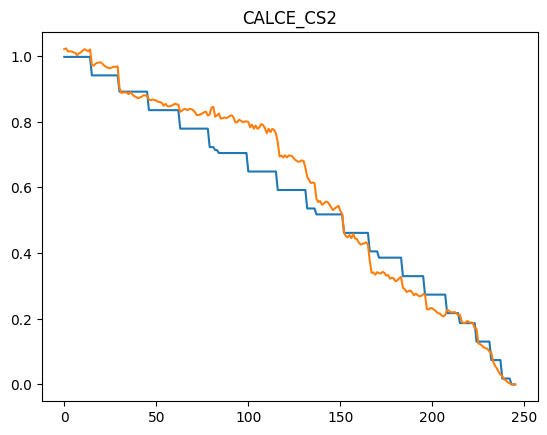

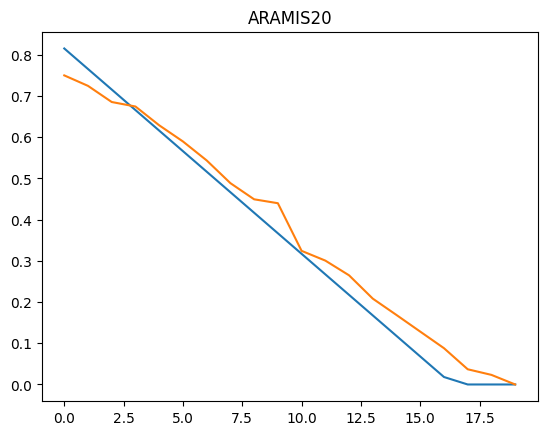

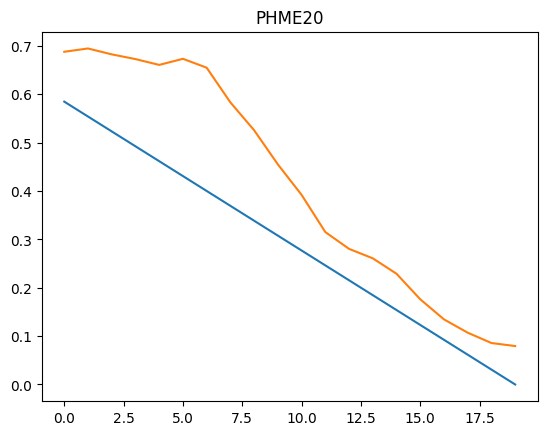

In [117]:
DATASETS = ['CALCE_CS2', 'ARAMIS20', 'PHME20']

for dataset in DATASETS:
    Y_aux, Y_pred, results = predictions[dataset]
    plt.plot(Y_aux)
    plt.plot(Y_pred) 
    plt.title(dataset)
    plt.show()